**<h1>Group Project</h1>**

**<h1>Crime Classification in San Francisco: Predicting Crime Categories Based on Time and Location</h1>**
---

> 

   **<h2>Group members</h2>**


*   Hranush Sahradyan
*   Hasmik Margaryan
*   Ishkhanuhi Hakwbyan


>

**<h2>Purpose of the project</h2>**

This assignment focuses on building a machine learning model for crime classification in San Francisco. The dataset used for this project contains approximately 12 years of crime reports from various neighborhoods in the city. The goal is to predict the category of crime based on the given time and location information.

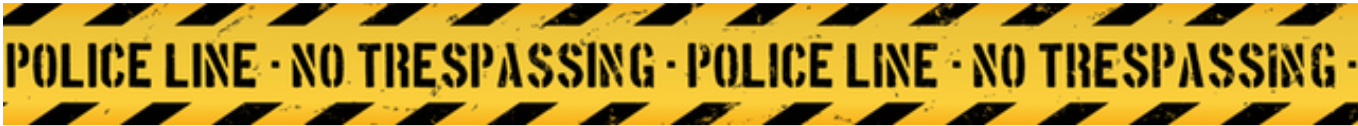


**<h2>Dataset Overview</h2>**

The dataset used in this project is sourced from Kaggle and provides comprehensive crime reports from 1934 to 1963. The dataset covers various neighborhoods in San Francisco, including Sunset, SOMA, Marina, and Excelsior. Each crime report entry includes information such as the date, time, and location of the crime, as well as the reported crime category. Here is the [kaggle page](https://www.kaggle.com/competitions/sf-crime/overview) of the assignment.


**<h2>Dataset Description</h2>**

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

**Data fields**
* **Dates** - timestamp of the crime incident
* **Category** - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
* **Descript** - detailed description of the crime incident (only in train.csv)
* **DayOfWeek** - the day of the week
* **PdDistrict** - name of the Police Department District
* **Resolution** - how the crime incident was resolved (only in train.csv)
* **Address** - the approximate street address of the crime incident 
* **X** - Longitude
* **Y** - Latitude




>
>
>
>
>
>
>
>
>
>
>
>
>
>
>


**<h2>Contents</h2>**


1.   [Data Cleaning and Preprocessing](#preproc)
3.   [EDA](#eda)

4.   [Feature Selection/Extraction](#fenigine)
4.   [MODEL](#models)...
    
    
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>

<a name="preproc"></a>
# Data Cleaning and Preprocessing

Import of libraries.

In [201]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
import contextily as ctx
import urllib
import shutil
import zipfile
import re

In [202]:
import geopandas as gpd
import fiona
from shapely.geometry import  Point
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(20,20))
from shapely import wkt
%matplotlib inline

Reading train and test datasets into dataframes.

In [203]:
sf_crime_data = pd.read_csv("train.csv", parse_dates=['Dates'])
sf_crime_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [204]:
df_test = pd.read_csv("test.csv", parse_dates=['Dates'])
df_test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


At first we can check for missing and duplicated values in our dataset.

In [205]:
sf_crime_data.info(),df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   Descript    878049 non-null  object        
 3   DayOfWeek   878049 non-null  object        
 4   PdDistrict  878049 non-null  object        
 5   Resolution  878049 non-null  object        
 6   Address     878049 non-null  object        
 7   X           878049 non-null  float64       
 8   Y           878049 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Id          884262 non-null  int64         
 1   Dates       88426

(None, None)

There are no missing values either in train nor in test set.

In [206]:
print(f'Duplicated values:\n Train set: {sf_crime_data.duplicated().sum()}\n Test set: {df_test.duplicated().sum()}')

Duplicated values:
 Train set: 2323
 Test set: 0


There are duplicates only in the train set, but they are very few compared to the whole data, so we remove them

In [207]:
sf_crime_data.drop_duplicates(inplace=True)

In the given dataset, the target variable is the "Category" column, which represents the category of the crime. There are two additional variables, "Descript" and "Resolution," that are only available for the training data.

In [208]:
sf_crime_data[['Category','Descript','Resolution']].head()

,Category,Descript,Resolution
0,WARRANTS,WARRANT ARREST,"ARREST, BOOKED"
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED"
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED"
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE


The "Descript" column provides a description or narrative of the crime incident. It may contain detailed information about the nature of the crime, the actions involved, or any other relevant details. However, in this project, we have decided to drop the "Descript" variable from the dataset.
The reason for dropping the "Descript" column is that it contains information that could potentially leak the target variable, "Category," to the model during training. Since the goal is to predict the crime category based solely on the given time and location information, including the "Descript" column could cause the model overly dependent on specific textual descriptions, rather than relying on the relevant features for classification.


In [209]:
sf_crime_data.drop('Descript', axis=1, inplace=True)

For feature "Resolution" we can see that using only features aviable in test set we can not restore it, also there are NONE values for almost 60% of out train set and it is not well defined whethe it ios NONE beacouse we dont no the resolution of crime or there were no resolution.So we decided to drop it too.

In [210]:
len(sf_crime_data[sf_crime_data['Resolution'] == 'NONE'])

525122

As mentiond the "Resolution" column is not available for the test set too.
Additionally,we found out there is a significant presence of "NONE" values in the "Resolution" column, accounting for nearly 60% of the training set. The meaning behind these "NONE" values is ambiguous, as it is unclear whether they indicate the absence of a resolution or simply missing information regarding the resolution of the crime. This lack of clarity further complicates the inclusion of the "Resolution" variable in the analysis.

Therefore, after careful consideration, it has been decided to drop the "Resolution" column from the dataset. The decision is based on the inability to restore this feature using only the available features in the test set and the lack of clear and consistent interpretation for the "NONE" values.

By removing the "Resolution" and "Discript" column, the focus of the project shifts to utilizing the given time and location information to predict the crime category accurately. This approach ensures a more robust and unbiased modeling process, where the model relies solely on objective features to classify crimes, without the potential biases and uncertainties associated with the "Resolution" variable.

In [211]:
sf_crime_data.drop('Resolution', axis=1, inplace=True)

In [212]:
sf_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875726 entries, 0 to 878048
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       875726 non-null  datetime64[ns]
 1   Category    875726 non-null  object        
 2   DayOfWeek   875726 non-null  object        
 3   PdDistrict  875726 non-null  object        
 4   Address     875726 non-null  object        
 5   X           875726 non-null  float64       
 6   Y           875726 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 53.5+ MB


In [213]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Id          884262 non-null  int64         
 1   Dates       884262 non-null  datetime64[ns]
 2   DayOfWeek   884262 non-null  object        
 3   PdDistrict  884262 non-null  object        
 4   Address     884262 non-null  object        
 5   X           884262 non-null  float64       
 6   Y           884262 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 47.2+ MB


As we can see there are no missing values.

In [214]:
# Defining the range for crimes
print('First date: ', str(sf_crime_data.Dates.min()))
print('Last date: ', str(sf_crime_data.Dates.max()))
sf_crime_data.shape

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00


(875726, 7)

Our train set contains data on crimes for 12 years, from January 2003 to May 2015, respectively, there is a lot of data - 875726 rows, while we have  different column signs.

In [215]:
# Defining the range for crimes
print('First date: ', str(df_test.Dates.min()))
print('Last date: ', str(df_test.Dates.max()))
df_test.shape

First date:  2003-01-01 00:01:00
Last date:  2015-05-10 23:59:00


(884262, 7)

Our test set contains data on crimes for 12 years, from January 2003 to May 2015, respectively, there is a lot of data - 884262 rows, while we have  different column signs.

Now we can explore other features.There are only two numeric features in the data - latitude and longitude.Let's see how all the given coordinates are located in space:

In [216]:
sf_crime_data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,875726.0,-122.422623,0.030363,-122.513642,-122.432952,-122.416446,-122.406959,-120.5
Y,875726.0,37.771032,0.457497,37.707879,37.752427,37.775421,37.784380,90.0


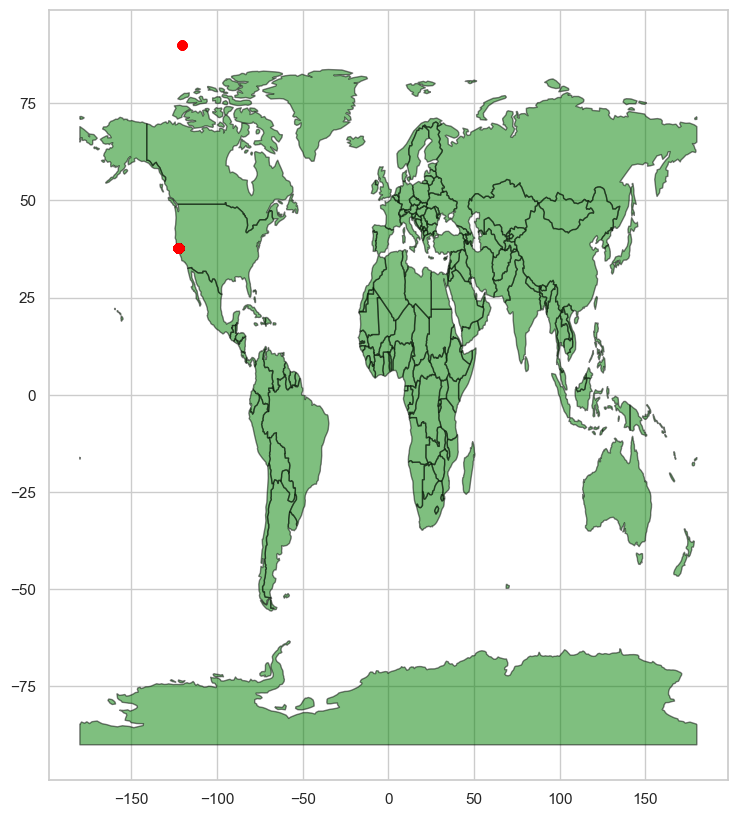

In [217]:
#Let's mark the points on the map (by latitude and longitude from the data) where exactly the crimes were committed:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(sf_crime_data)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(14,10), color='green', edgecolor='black', alpha=0.5)

train_gdf.plot(ax=ax, color='red')
plt.show()

All coordinates from the dataset are grouped into two red dots on the map. The lower group of points is located in the San Francisco area, and the upper group of points does not fall on land on the map (not even area of USA), it seems that this is  incorrect data. Let's see how many points got there (we see that the points lie above the longitude of 75.0):

In [218]:
print(train_gdf.loc[train_gdf.Y > 75].count()[0])
train_gdf.loc[train_gdf.Y > 75].sample(5)

67


,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,Coordinates
842261,2003-06-25 07:30:00,VEHICLE THEFT,Wednesday,RICHMOND,JOHN F KENNEDY DR / MARTIN LUTHER KING JR DR,-120.5,90.0,POINT (-120.50000 90.00000)
678326,2005-10-04 09:00:00,LARCENY/THEFT,Tuesday,INGLESIDE,PERSIA AV / LAGRANDE AV,-120.5,90.0,POINT (-120.50000 90.00000)
839585,2003-07-08 19:22:00,WARRANTS,Tuesday,SOUTHERN,1ST ST / BRANNAN ST,-120.5,90.0,POINT (-120.50000 90.00000)
756059,2004-08-19 03:43:00,OTHER OFFENSES,Thursday,BAYVIEW,I-280 / PENNSYLVANIA AV,-120.5,90.0,POINT (-120.50000 90.00000)
772415,2004-05-28 18:15:00,SUSPICIOUS OCC,Friday,BAYVIEW,I-280 / CESAR CHAVEZ ST,-120.5,90.0,POINT (-120.50000 90.00000)


Only 67 incorrect values, we can drop it. And check the same conditions for test set to.

In [219]:
sf_crime_data = sf_crime_data[sf_crime_data['Y'] <= 75]

df_test = df_test[df_test['Y'] <= 75]

print("Shape of df_test:", df_test.shape)
print("Shape of sf_crime_data:", sf_crime_data.shape)

Shape of df_test: (884186, 7)
Shape of sf_crime_data: (875659, 7)


Let's see what we have for other features and see if there is a need of preprocessing there.

In [220]:
unique_counts = sf_crime_data.Category.value_counts()

In [221]:
sf_crime_data.DayOfWeek.value_counts()

Friday       133360
Wednesday    128818
Saturday     126463
Thursday     124746
Tuesday      124592
Monday       121292
Sunday       116388
Name: DayOfWeek, dtype: int64

In [222]:
sf_crime_data.PdDistrict.value_counts()

SOUTHERN      156520
MISSION       119722
NORTHERN      105093
BAYVIEW        89089
CENTRAL        85262
TENDERLOIN     81627
INGLESIDE      78718
TARAVAL        65396
PARK           49159
RICHMOND       45073
Name: PdDistrict, dtype: int64

There is no anomal values in target, PdDistrict and DayOfWeek variables, so there is no need for any modification.

<a name="eda"></a>
# EDA

Let's see how many crimes per day (hour) were committed in San Francisco.

In [223]:
import plotly.io as pio
pio.templates.default = "ggplot2"
pio.templates.default_layout = {'colorway': sns.color_palette()}

In the exploratory data analysis (EDA) phase, we will begin by examining the target variable and then delve into exploring the features related to time and location of the crimes.

We will start by focusing our attention on the target variable, which represents the category of the crime. This initial analysis will provide insights into the distribution and patterns of different types of crimes in the dataset.

Following the examination of the target variable, we will shift our focus to the temporal aspects of the crimes. This exploration will involve studying the time-related features, such as the hour of the day or the day of the week when the crimes occurred. By analyzing these temporal patterns, we can gain a deeper understanding of any temporal trends or patterns in criminal activities.

Furthermore, we will explore the geographic variables associated with the crimes. This analysis will involve investigating the locations or neighborhoods where the crimes were committed. By examining the spatial distribution of crimes, we can identify any specific areas that may have higher or lower crime rates.

By conducting a comprehensive analysis of the target variable, along with the temporal and geographic features, we aim to uncover valuable insights and patterns that can contribute to building an effective machine learning model for crime classification.

count        39.000000
mean      22452.794872
std       37967.112752
min           6.000000
25%        1185.500000
50%        4379.000000
75%       28530.500000
max      174305.000000
Name: Category, dtype: float64


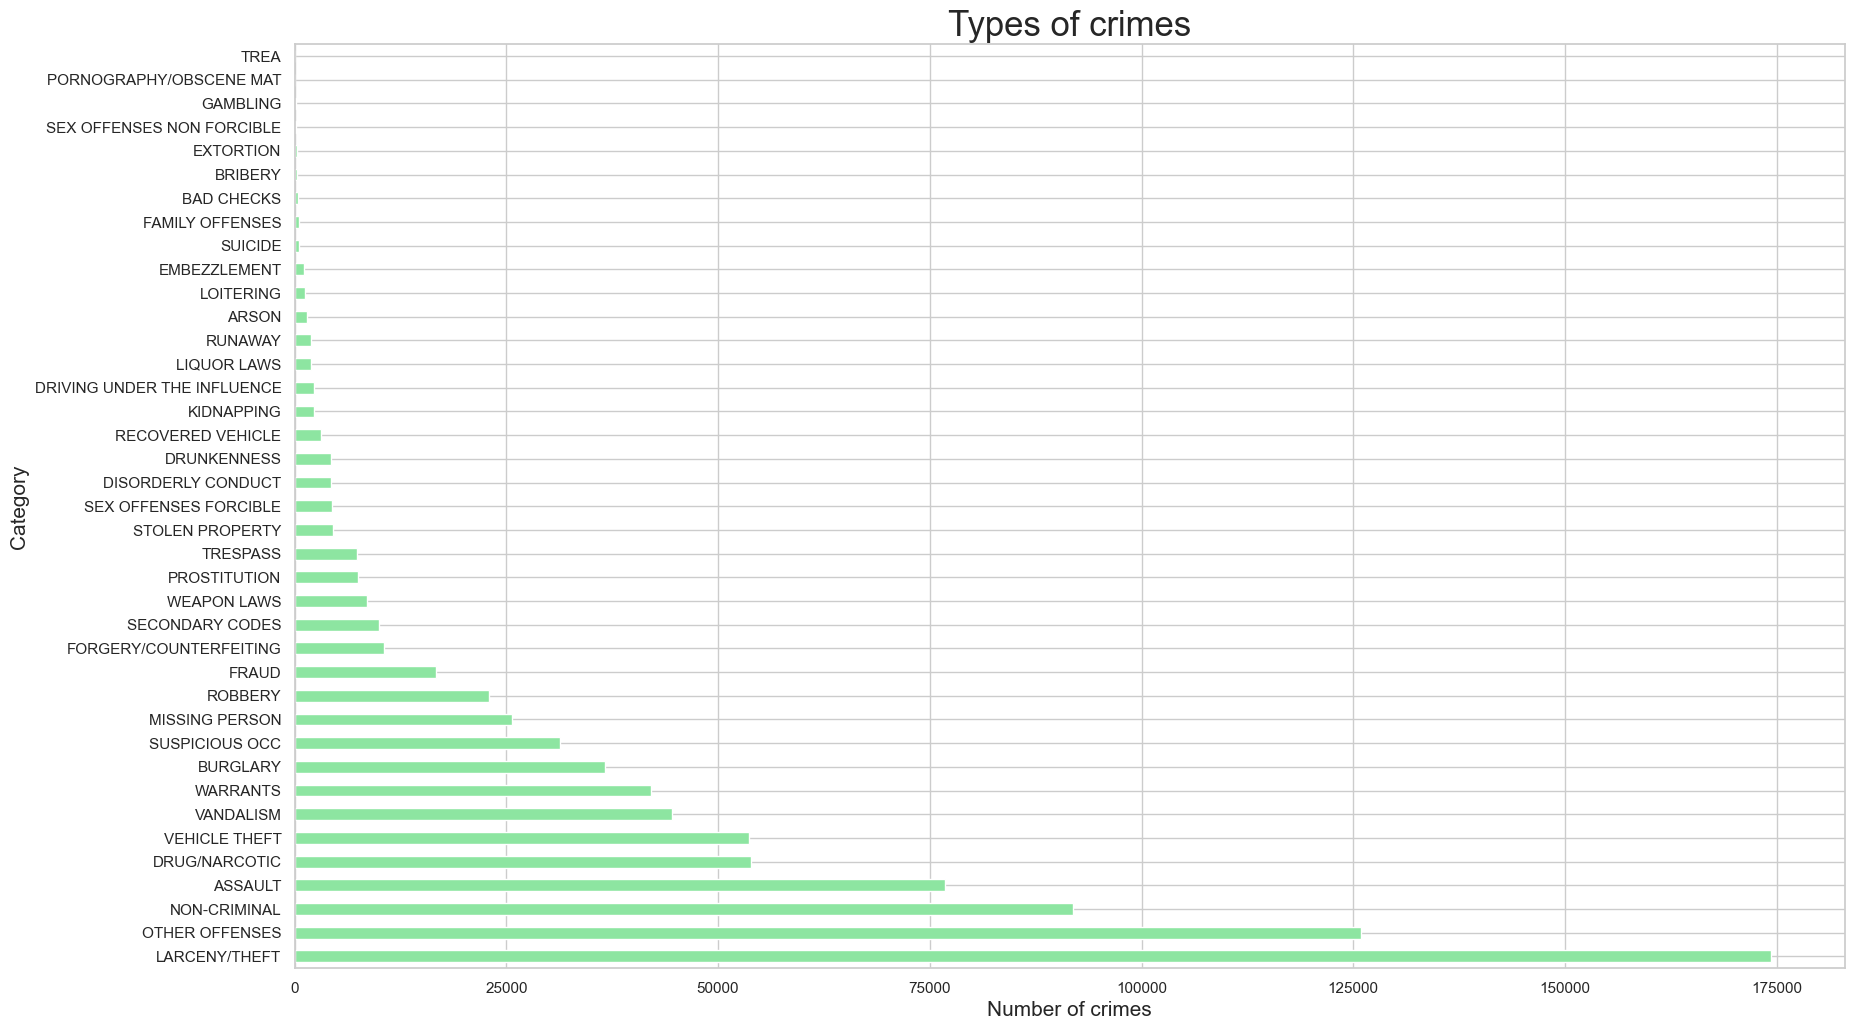

In [224]:
# Оценим, какие именно преступления чаще всего происходят в Сан-Франциско:

kind = sf_crime_data['Category'].value_counts()
print(kind.describe())
kind.plot(kind="barh",figsize=(20,12),  color='g')

plt.ylabel('Category',fontsize=15)
plt.xlabel('Number of crimes',fontsize=15)
plt.title('Types of crimes',fontsize=25)
plt.show()

In [226]:
sf_crime_data['Date'] = sf_crime_data.Dates.dt.date
sf_crime_data['Time'] = sf_crime_data.Dates.dt.time
sf_crime_data['Hour'] = sf_crime_data.Dates.dt.hour
sf_crime_data['Month'] = sf_crime_data.Dates.dt.month
sf_crime_data['Day'] = sf_crime_data.Dates.dt.day
sf_crime_data['Year'] = sf_crime_data.Dates.dt.year

count    2249.000000
mean      389.354824
std        48.506406
min         2.000000
25%       360.000000
50%       389.000000
75%       420.000000
max       650.000000
Name: Dates, dtype: float64


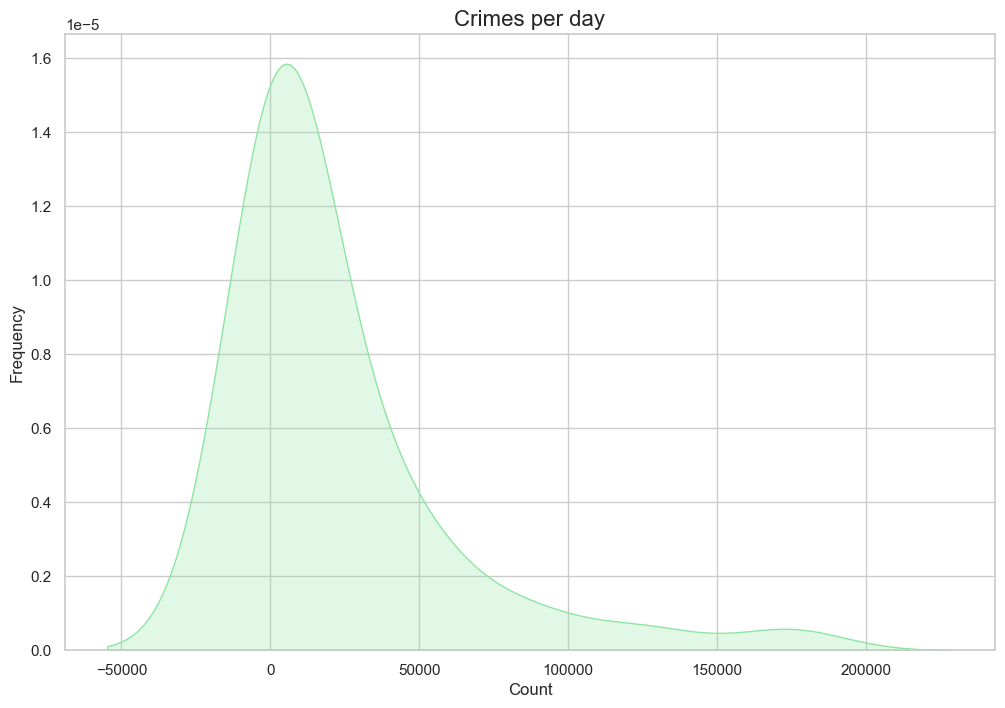

In [227]:
daily = sf_crime_data.groupby('Date').count().iloc[:, 0]
print(daily.describe())

col = sns.color_palette()

plt.figure(figsize=(12, 8))
sns.kdeplot(data=data, shade=True, color='g')

plt.title('Crimes per day', fontdict={'fontsize': 16})
plt.xlabel('Count')
plt.ylabel('Frequency')

plt.show()

In [228]:
week = sf_crime_data['DayOfWeek'].value_counts()

fig = px.bar(week, x=week.index, y=week.values)

fig.update_layout(title='Crime Count by Day of Week')
fig.update_xaxes(title='Day of Week')
fig.update_yaxes(title='Count')

fig.show()

The graph shows that most crimes were committed on Fridays, and the quietest day is Sunday, however, on average, the number of crimes is approximately the same on the days of the week.

In [229]:
week = sf_crime_data['Year'].value_counts()

fig = px.bar(week, x=week.index, y=week.values)

fig.update_layout(title='Crime Count by Year')
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Count')

fig.show()

In [230]:
grouped_data = sf_crime_data.groupby(['Year', 'Category']).size().reset_index(name='Count')
fig = px.bar(grouped_data, x='Year', y='Count', color='Category', 
             title='Crime Categories by Hour', labels={'Hour': 'Hour of the Day', 'Count': 'Count'})
fig.show()

In [231]:
hour_counts = sf_crime_data['Hour'].value_counts()

fig = px.bar(hour_counts, x=hour_counts.index, y=hour_counts.values)

fig.update_layout(title='Crime Count by Hour of Day',
                  xaxis_title='Hour of Day',
                  yaxis_title='Count')

fig.show()

The graph shows a decrease in the number of crimes reported between the hours of 1 and 7 o'clock.

In [232]:
grouped_data = sf_crime_data.groupby(['Hour', 'Category']).size().reset_index(name='Count')
fig = px.bar(grouped_data, x='Hour', y='Count', color='Category', 
             title='Crime Categories by Hour', labels={'Hour': 'Hour of the Day', 'Count': 'Count'})
fig.show()

In [233]:
grouped_data = sf_crime_data.groupby(['Hour', 'PdDistrict']).size().reset_index(name='Count')
fig = px.bar(grouped_data, x='Hour', y='Count', color='PdDistrict', 
             title='Crime Distinct by Hour', labels={'Hour': 'Hour of the Day', 'Count': 'Count'})
fig.show()

count        10.000000
mean      87565.900000
std       33315.506148
min       45073.000000
25%       68726.500000
50%       83444.500000
75%      101092.000000
max      156520.000000
Name: PdDistrict, dtype: float64


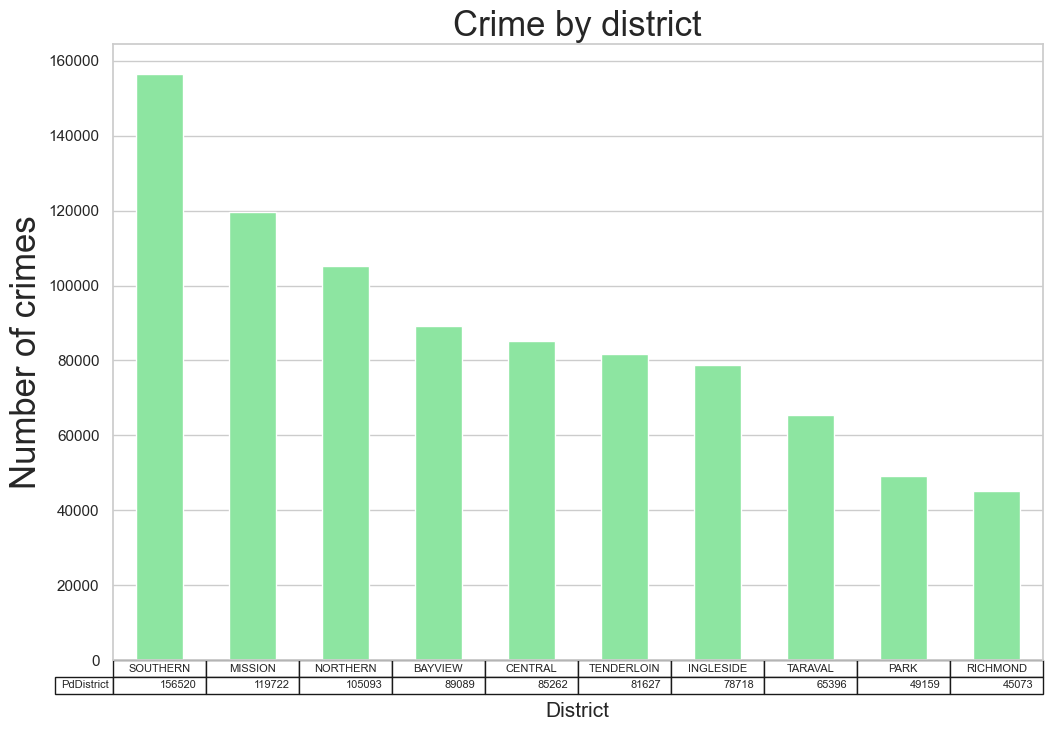

In [234]:
dist = sf_crime_data["PdDistrict"].value_counts()
dist.plot(kind="bar",figsize=(12,8), table=True,  color='g')
print(dist.describe())
plt.xticks([])
plt.xlabel('District',fontsize=15,labelpad=30)
plt.ylabel('Number of crimes',fontsize=25)
plt.title('Crime by district',fontsize=25)
plt.show()

In [235]:
geometry2 = [Point(xy) for xy in zip(sf_crime_data['X'], sf_crime_data['Y'])]

In [236]:
! wget https://www2.census.gov/geo/tiger/TIGER2017//ROADS/tl_2017_06075_roads.zip -q

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [237]:
!unzip "./tl_2017_06075_roads.zip" -d shapefiles

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [238]:
# Переводим shapefile в GeoDataFrame

geo_df = gpd.read_file('shapefiles/tl_2017_06075_roads.shp')
geo_df = geo_df.to_crs(epsg=3857)

# Преобразуем Pandas DataFrame в GeoDataFrame

crime_geo_df = gpd.GeoDataFrame(df_train, geometry=geometry2)

# Инициализируем систему координат crs на 4326, проекция на эллипсоид, 
# т.к. в таком формате представлены данные в geometry

crime_geo_df.crs = "EPSG:4326"

# Изменяем crs на Меркатор, чтобы кодировка координат соответствовала 
# San-Francisco GeoDataFrame

crime_geo_df = crime_geo_df.to_crs(epsg = 3857)

# Настройка оптимизации вывода карты

sns.set_context("paper", font_scale=2)
# Создаём карту

fig, ax = plt.subplots(figsize=(20,20))

# Наносим наш слой SF GeoDataFrame

geo_df.plot(ax=ax, alpha = .1)

# Наносим точки совершения преступлений

crime_geo_df.plot(ax=ax, column = 'Category', cmap = 'brg', marker = '.', \
                  markersize=100, edgecolor = 'black', alpha=1, legend = True)  

# Добавляем рельеф и объекты на карту, используя contextily

ctx.add_basemap(ax, )

# Отключаем оси с координатами в формате Меркатор 
# (проекция на цилиндр, ось = ось Земли)

ax.set_axis_off()

fig.tight_layout()
plt.title("Преступления в Сан-Франциско")
plt.savefig('SF_crime_areas.png');


DriverError: shapefiles/tl_2017_06075_roads.shp: No such file or directory

In [ ]:
data = sf_crime_data.groupby('Category').count().iloc[:, 0].sort_values(ascending=False)
data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=(data.values / data.values.sum()) * 100,
        y=data.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()


In [ ]:
# Downloading the shapefile of the area
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train_gdf.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train_gdf.groupby('Dates').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()


<a name="fenigine"></a>
# Feature Selection/Extraction

Adding features like whether the crime was committed on holidays or how far was the address from the police stations maybe will help on classification task. So we're going to add is_holiday and distance_from_pd


In [239]:
import holidays

us_holidays = holidays.US()

sf_crime_data['is_holiday'] = sf_crime_data['Dates'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

In [240]:
sf_crime_data['is_holiday'].value_counts()

0    847693
1     27966
Name: is_holiday, dtype: int64

In [241]:
# Filter the dataset for only holidays
holiday_data = sf_crime_data[sf_crime_data['is_holiday'] == 1]

# Group by 'Category', count and sort
most_common_holiday_crimes = holiday_data.groupby('Category').size().sort_values(ascending=False)

# Print the results
most_common_holiday_crimes

Category
LARCENY/THEFT                  5310
OTHER OFFENSES                 4194
NON-CRIMINAL                   3079
ASSAULT                        2545
DRUG/NARCOTIC                  1748
VEHICLE THEFT                  1667
VANDALISM                      1438
WARRANTS                       1379
BURGLARY                       1117
SUSPICIOUS OCC                 1037
MISSING PERSON                  764
ROBBERY                         722
FRAUD                           474
SECONDARY CODES                 339
WEAPON LAWS                     301
FORGERY/COUNTERFEITING          292
TRESPASS                        259
SEX OFFENSES FORCIBLE           159
STOLEN PROPERTY                 157
DRUNKENNESS                     140
DISORDERLY CONDUCT              134
DRIVING UNDER THE INFLUENCE     107
KIDNAPPING                      103
RECOVERED VEHICLE                83
RUNAWAY                          63
PROSTITUTION                     58
LIQUOR LAWS                      57
LOITERING          

In [248]:
crime_count_by_holiday = sf_crime_data.groupby('is_holiday').size().reset_index(name='Crime Count')

fig = px.bar(crime_count_by_holiday, x='is_holiday', y='Crime Count',
             labels={'is_holiday': 'Is Holiday', 'Crime Count': 'Crime Count'},
             title='Crime Count by Holiday')

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['Not a Holiday', 'Holiday']
    )
)

fig.show()

Next, we want to determine the distance from crime address to district's police station.

In [242]:
sf_crime_data['PdDistrict'].value_counts()

SOUTHERN      156520
MISSION       119722
NORTHERN      105093
BAYVIEW        89089
CENTRAL        85262
TENDERLOIN     81627
INGLESIDE      78718
TARAVAL        65396
PARK           49159
RICHMOND       45073
Name: PdDistrict, dtype: int64

In [244]:
from geopy.distance import geodesic


# Police station coordinates
police_stations = {
    'CENTRAL': (37.7986, -122.4101),
    'SOUTHERN': (37.77528, -122.40417),
    'BAYVIEW': (37.7298, -122.3977),
    'MISSION': (37.7628, -122.4220),
    'NORTHERN': (37.7802, -122.4324),
    'PARK': (37.76777, -122.45517),
    'RICHMOND': (37.7801, -122.4644),
    'INGLESIDE': (37.7247, -122.4463),
    'TARAVAL': (37.7437, -122.4815),
    'TENDERLOIN': (37.78368, -122.41292)
}

def calculate_distance(loc1, loc2):
    return geodesic(loc1, loc2).miles

sf_crime_data['distance_from_pd'] = sf_crime_data.apply(lambda row: calculate_distance((row['Y'], row['X']), police_stations[row['PdDistrict']]), axis=1)


In [245]:
sf_crime_data.head()

,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,Date,Time,Hour,Month,Day,Year,is_holiday,distance_from_pd
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23:53:00,23,5,13,2015,0,0.525518
1,2015-05-13 23:53:00,OTHER OFFENSES,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23:53:00,23,5,13,2015,0,0.525518
2,2015-05-13 23:33:00,OTHER OFFENSES,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13,23:33:00,23,5,13,2015,0,1.461881
3,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13,23:30:00,23,5,13,2015,0,1.456104
4,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13,23:30:00,23,5,13,2015,0,0.936463
